[*********************100%%**********************]  1 of 1 completed


7/7 [==============================] - 0s 411us/step
Average percentage change after Isolation Forest anomalies: 0.42783873602602013
Average percentage change after One-Class SVM anomalies: -0.3424287836421608
No Autoencoder anomalies detected.


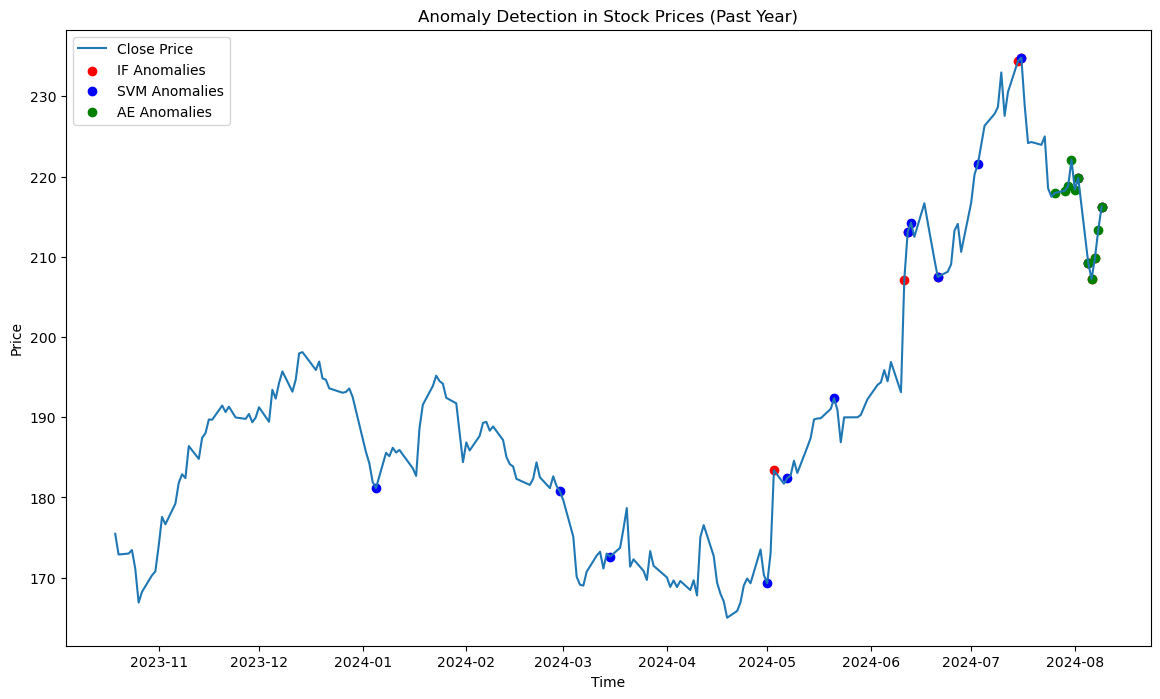

In [6]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Download data
ticker = 'AAPL'
data = yf.download(ticker, period='1y', interval='1d')

# Feature Engineering
data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()
delta = data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Drop missing values
data.dropna(inplace=True)

# Prepare features
features = data[['Close', 'Volume', 'MA10', 'MA50', 'RSI']]

# Scale data
scaler = RobustScaler()
data_scaled = scaler.fit_transform(features)

# Isolation Forest
isolation_forest = IsolationForest(contamination=0.05, n_estimators=1000, random_state=0)
data['anomaly_if'] = isolation_forest.fit_predict(data_scaled)

# One-Class SVM
one_class_svm = OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')
data['anomaly_svm'] = one_class_svm.fit_predict(data_scaled)

# Autoencoders
input_dim = data_scaled.shape[1]
encoding_dim = 3

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="linear")(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(data_scaled, data_scaled, epochs=100, batch_size=32, shuffle=True, validation_split=0.1, verbose=0)

reconstructions = autoencoder.predict(data_scaled)
mse = np.mean(np.power(data_scaled - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 95)
data['anomaly_ae'] = mse > threshold


# Calculate percentage change after anomalies
def calculate_change(data, anomaly_column):
    changes = []
    anomaly_indices = data.index[data[anomaly_column] == -1]
    for i in anomaly_indices:
        if i + pd.Timedelta(days=1) in data.index:
            future_price = data.loc[i + pd.Timedelta(days=1), 'Close']
            current_price = data.loc[i, 'Close']
            change = ((future_price - current_price) / current_price) * 100
            changes.append(change)
    return changes

if_changes = calculate_change(data, 'anomaly_if')
svm_changes = calculate_change(data, 'anomaly_svm')
ae_changes = calculate_change(data, 'anomaly_ae')

# Print average percentage changes, handle empty lists
if if_changes:
    print("Average percentage change after Isolation Forest anomalies:", np.mean(if_changes))
else:
    print("No Isolation Forest anomalies detected.")

if svm_changes:
    print("Average percentage change after One-Class SVM anomalies:", np.mean(svm_changes))
else:
    print("No One-Class SVM anomalies detected.")

if ae_changes:
    print("Average percentage change after Autoencoder anomalies:", np.mean(ae_changes))
else:
    print("No Autoencoder anomalies detected.")


# Plotting
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['Close'], label='Close Price')
plt.scatter(data.index[data['anomaly_if'] == -1], data['Close'][data['anomaly_if'] == -1], color='red', label='IF Anomalies')
plt.scatter(data.index[data['anomaly_svm'] == -1], data['Close'][data['anomaly_svm'] == -1], color='blue', label='SVM Anomalies')
plt.scatter(data.index[data['anomaly_ae']], data['Close'][data['anomaly_ae']], color='green', label='AE Anomalies')

plt.title('Anomaly Detection in Stock Prices (Past Year)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()